In [1]:
using Distributed
@everywhere using DrWatson
@everywhere begin
        quickactivate(@__DIR__, "Ant_Model")
        using Parameters
        include(srcdir("antmodel_pde.jl"))
        include(srcdir("accessory","config.jl"))
end

using PyPlot
using LaTeXStrings
using PyCall
@pyimport numpy as np
@pyimport matplotlib.colors as colors2
rc("text", usetex=false) 
rc("mathtext", fontset="cm")
rc("font", family="serif", serif="cmr10", size=12)
rc("axes.formatter", use_mathtext = true)
params = dict_list(Dict(
    :Tf => 5.0,
    :Model => :modelParaEllplusLA,
    :Δt => 1e-5,
    :v0 => [1.5,3.5],
    :DR => 1.0,
    :DT => 0.01,
    :D => 1.0,
    :α => 1.0,
    :η => 1.0,
    :γ => 325.0, 
    :Nx => 31,
    :Ny => 31,
    :Nθ => 21,
    :λ1 => 0.1, 
    :IC => "rand_unif_seed",
    :seed1 => 4472,
    :saveplot => true
)) .|> (p->MyParams(; pairs(p)...))


iout = pmap(run_or_load_active_pde, params);

┌ Warning: Passing arbitrary keyword arguments in `produce_or_load`, with the goal of
│ forwarding them to `savename` is deprecated. Instead, just create a function
│ for the keyword `filename` as `filename = config -> savename(config; kwargs...)`
└ @ DrWatson /Users/oscardewit/.julia/packages/DrWatson/86H4O/src/saving_files.jl:76
┌ Warning: Passing arbitrary keyword arguments in `produce_or_load`, with the goal of
│ forwarding them to `savename` is deprecated. Instead, just create a function
│ for the keyword `filename` as `filename = config -> savename(config; kwargs...)`
└ @ DrWatson /Users/oscardewit/.julia/packages/DrWatson/86H4O/src/saving_files.jl:76


In [2]:
k=1
@unpack γ, DT, λ1, Nx, Ny, Tf, IC, v0, seed1 = params[k]
@unpack x, y, θ, pdesim, Δx, Δy, Δθ = iout[k][1];
@unpack F, C, Rho, P, T = pdesim;

x1 = x;
y1 = y;
θ1 = θ;

Cos2θ = cos.(2*θ); Sin2θ = sin.(2*θ);

xθ = [x̃ for x̃ ∈ x1, θ̃ ∈ θ]
θx = [θ̃ for x̃ ∈ x1, θ̃ ∈ θ]
xx = [x̃ for x̃ ∈ x1, ỹ ∈ y1]
yy = [ỹ for x̃ ∈ x1, ỹ ∈ y1]
x2, y2 = np.meshgrid(x, y, indexing = "ij", sparse = false)


Pend = P[end,:,:,:]
ts = [1,3,5,50]

4-element Vector{Int64}:
  1
  3
  5
 50

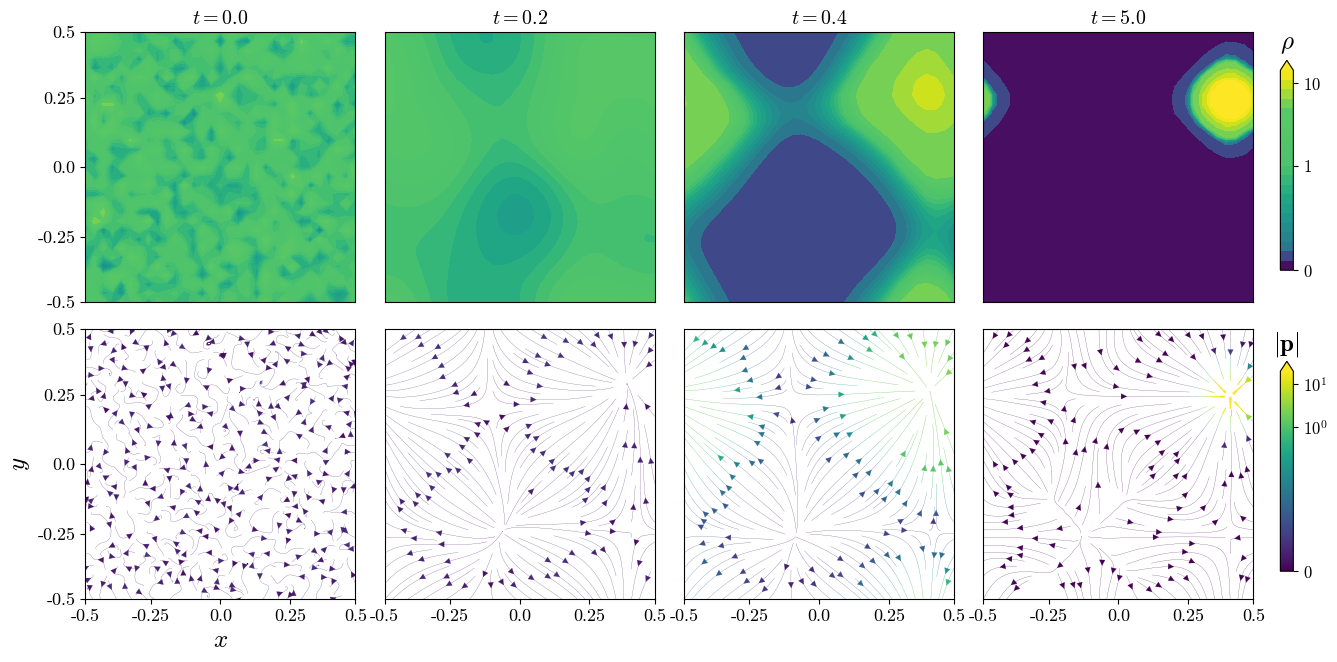

In [3]:

fig, axs = plt.subplots(2, size(ts)[1], figsize=(13,7))
images = []

Pnend = (sqrt.(P[end,1,:,:]'.^2 .+ P[end,2,:,:]'.^2));

ts2 = [round((t-1)*(Tf/49),digits=1) for t ∈ ts]
colmap = PyPlot.plt.cm.viridis
norm2 = colors2.SymLogNorm(linthresh=1.0,linscale=3.0,vmin=0.0,vmax=20.0);
levels1 = [0,0.1,0.5,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05,1.1,1.15,1.2,1.25,1.3,3.0,6.0,12.0,20.0]
for j ∈ 1:size(ts)[1]
    push!(images,axs[1,j].contourf(xx,yy,Rho[ts[j],:,:],levels=levels1,norm=norm2,extend="max"))
    axs[1,j].set_xticks([])
    axs[1,j].set_title(L"t=%$(ts2[j])")
    Pn = (sqrt.(P[ts[j],1,:,:]'.^2 .+ P[ts[j],2,:,:]'.^2));
    lw = 0.15.+2.0*Pn./findmax(Pnend)[1]
    push!(images, axs[2,j].streamplot(x2', y2', P[ts[j],1,:,:]', P[ts[j],2,:,:]', color=Pn, norm=norm2, cmap=colmap, linewidth=lw,density=1.2))
end

for j ∈ 1:4
    axs[1,j].set_aspect("equal")
    axs[2,j].set_aspect("equal")
    axs[1,j].set_xlim(x[1],x[end])
    axs[1,j].set_ylim(y[1],y[end])
    axs[2,j].set_xlim(x[1],x[end])
    axs[2,j].set_ylim(y[1],y[end])
end

for j ∈ 2:4
    axs[2,j].set_yticks([])
    axs[1,j].set_yticks([])
end

tickfontsize = 13
labelfontsize = 18
axs[2,1].set_xticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[2,1].set_xticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)
axs[2,1].set_xlabel(L"x",fontsize=labelfontsize)
axs[2,1].set_yticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[2,1].set_yticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)
axs[2,1].set_ylabel(L"y",fontsize=labelfontsize)
axs[1,1].set_yticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[1,1].set_yticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)
axs[2,2].set_xticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[2,2].set_xticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)
axs[2,3].set_xticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[2,3].set_xticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)
axs[2,4].set_xticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[2,4].set_xticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)

fig.subplots_adjust(top=0.92,right=0.93,left=0.03,wspace=0.1,hspace=0.1)
cbar_ax_rho = fig.add_axes([0.95, 0.58, 0.01, 0.30])
cbar_ax_p = fig.add_axes([0.95, 0.15, 0.01, 0.30])
cbar_ax_rho1 = fig.colorbar(images[7], cax=cbar_ax_rho,extend="max",shrink=0.9,ticks=[0,1,10])
cbar_ax_p1 = fig.colorbar(images[8].lines, cax=cbar_ax_p,extend="max",shrink=0.9,ticks=[0,1,10])
cbar_ax_rho1.ax.set_title(L"\rho",fontsize=labelfontsize,pad=15)
cbar_ax_p1.ax.set_title(L"|\mathbf{p}|",fontsize=labelfontsize,pad=15)
display(fig)
# fig.savefig("rho_P_λ=0.1_γ=$(γ)_$(IC)_seed=$(seed1)_v0=$(v0).png",bbox_inches="tight")
# fig.savefig("rho_P_λ=0.1_γ=$(γ)_$(IC)_seed=$(seed1)_v0=$(v0).eps",bbox_inches="tight")
close(fig)

In [4]:
k=2
@unpack γ, DT, λ1, Nx, Ny, Tf, IC, v0, seed1 = params[k]
@unpack x, y, θ, pdesim, Δx, Δy, Δθ = iout[k][1];
@unpack F, C, Rho, P, T = pdesim;

Pend = P[end,:,:,:]

2×31×31 Array{Float64, 3}:
[:, :, 1] =
 -0.00715504  -0.000881098  -0.000175552  …  -0.78029    -0.084541
 -3.64515e-7  -3.27639e-8   -5.87429e-9      -9.0442e-5  -7.2693e-6

[:, :, 2] =
 -0.00715504  -0.0008811   -0.000175552  …  -0.780285    -0.0845407
 -3.64977e-7  -3.34831e-8  -6.04526e-9      -9.06225e-5  -7.18597e-6

[:, :, 3] =
 -0.00715504  -0.000881102  -0.000175553  …  -0.78028     -0.0845405
 -3.65805e-7  -3.47435e-8   -6.34491e-9      -9.09432e-5  -7.04054e-6

;;; … 

[:, :, 29] =
 -0.00715504  -0.000881092  -0.00017555  …  -0.780305    -0.0845419
 -3.65433e-7  -3.4031e-8    -6.17557e-9     -9.07858e-5  -7.12605e-6

[:, :, 30] =
 -0.00715504  -0.000881094  -0.000175551  …  -0.7803      -0.0845416
 -3.64748e-7  -3.30436e-8   -5.94081e-9      -9.05254e-5  -7.23871e-6

[:, :, 31] =
 -0.00715504  -0.000881096  -0.000175551  …  -0.780295    -0.0845413
 -3.64437e-7  -3.26154e-8   -5.83899e-9      -9.04092e-5  -7.28712e-6

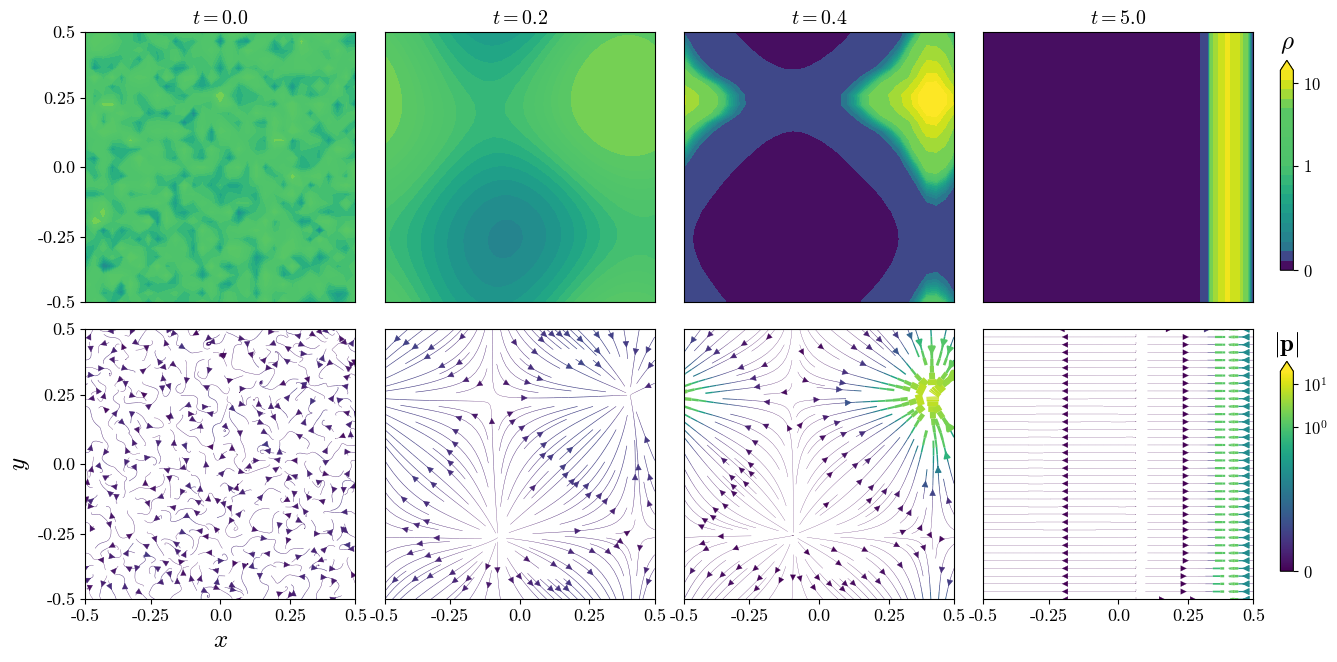

In [5]:

fig, axs = plt.subplots(2, size(ts)[1], figsize=(13,7))
images = []

Pnend = (sqrt.(P[end,1,:,:]'.^2 .+ P[end,2,:,:]'.^2));

for j ∈ 1:size(ts)[1]
    push!(images,axs[1,j].contourf(xx,yy,Rho[ts[j],:,:],levels=levels1,norm=norm2,extend="max"))
    axs[1,j].set_xticks([])
    axs[1,j].set_title(L"t=%$(ts2[j])")
    Pn = (sqrt.(P[ts[j],1,:,:]'.^2 .+ P[ts[j],2,:,:]'.^2));
    lw = 0.15.+2.0*Pn./findmax(Pnend)[1]
    push!(images, axs[2,j].streamplot(x2', y2', P[ts[j],1,:,:]', P[ts[j],2,:,:]', color=Pn, norm=norm2, cmap=colmap, linewidth=lw,density=1.2))
end

for j ∈ 1:4
    axs[1,j].set_aspect("equal")
    axs[2,j].set_aspect("equal")
    axs[1,j].set_xlim(x[1],x[end])
    axs[1,j].set_ylim(y[1],y[end])
    axs[2,j].set_xlim(x[1],x[end])
    axs[2,j].set_ylim(y[1],y[end])
end

for j ∈ 2:4
    axs[2,j].set_yticks([])
    axs[1,j].set_yticks([])

end

axs[2,1].set_xticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[2,1].set_xticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)
axs[2,1].set_xlabel(L"x",fontsize=labelfontsize)
axs[2,1].set_yticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[2,1].set_yticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)
axs[2,1].set_ylabel(L"y",fontsize=labelfontsize)
axs[1,1].set_yticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[1,1].set_yticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)
axs[2,2].set_xticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[2,2].set_xticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)
axs[2,3].set_xticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[2,3].set_xticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)
axs[2,4].set_xticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs[2,4].set_xticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=tickfontsize)

fig.subplots_adjust(top=0.92,right=0.93,left=0.03,wspace=0.1,hspace=0.1)
cbar_ax_rho = fig.add_axes([0.95, 0.58, 0.01, 0.30])
cbar_ax_p = fig.add_axes([0.95, 0.15, 0.01, 0.30])
cbar_ax_rho1 = fig.colorbar(images[7], cax=cbar_ax_rho,extend="max",shrink=0.9,ticks=[0,1,10])
cbar_ax_p1 = fig.colorbar(images[8].lines, cax=cbar_ax_p,extend="max",shrink=0.9,ticks=[0,1,10])
cbar_ax_rho1.ax.set_title(L"\rho",fontsize=labelfontsize,pad=15)
cbar_ax_p1.ax.set_title(L"|\mathbf{p}|",fontsize=labelfontsize,pad=15)
display(fig)
# fig.savefig("rho_P_λ=0.1_γ=$(γ)_$(IC)_seed=$(seed1)_v0=$(v0).png",bbox_inches="tight")
# fig.savefig("rho_P_λ=0.1_γ=$(γ)_$(IC)_seed=$(seed1)_v0=$(v0).eps",bbox_inches="tight")
close(fig)


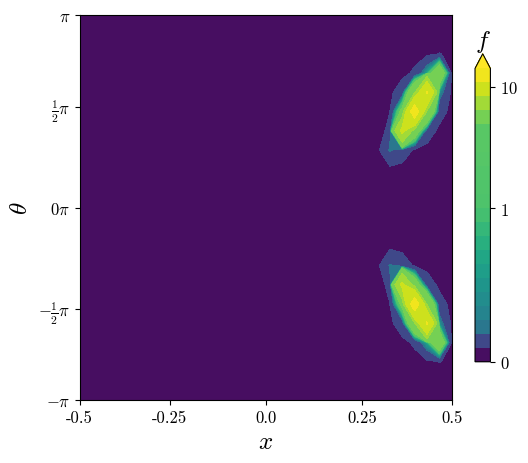

In [7]:
Fend = F[end,:,:,:]

fig, axs = plt.subplots(1, 1, figsize=(6,5))
images = []

push!(images,axs.contourf(xθ,θx,Fend[:,10,:],levels=levels1,norm=norm2,extend="max"))

axs.set_yticks([θ[1],-pi/2,0,pi/2,θ[end]])
axs.set_yticklabels([L"-\pi",L"-\frac{1}{2}\pi",L"0\pi",L"\frac{1}{2}\pi",L"\pi"],fontsize=12)
axs.set_ylabel(L"\theta",fontsize=labelfontsize)

axs.set_xticks([x1[1],-0.25,0.0,0.25,x1[end]])
axs.set_xticklabels([-0.5,-0.25,0.0,0.25,0.5],fontsize=12)
axs.set_xlabel(L"x",fontsize=labelfontsize)

cb = fig.colorbar(images[end],ax=axs,shrink=0.8,ticks=[0,1,10])
cb.ax.set_title(L"f",fontsize=labelfontsize,pad=15)

display(fig)
# fig.savefig("fxθ_λ=0.1_γ=$(γ)_$(IC)_seed=$(seed1)_v0=$(v0).png",bbox_inches="tight")
# fig.savefig("fxθ_P_λ=0.1_γ=$(γ)_$(IC)_seed=$(seed1)_v0=$(v0).eps",bbox_inches="tight")
close(fig)